In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import pi, sqrt
from fractions import Fraction
import logging
from skopt.dftbutils.lattice import Lattice
from skopt.dftbutils.querykLines import get_klines
np.set_printoptions(precision=2, suppress=True)
logger = logging.getLogger(__name__)

In [2]:
s1 = '0.5'
s2 = '1/2'
r1 = Fraction(s1)
r2 = Fraction(s2)
print (r1)
print (r2)

1/2
1/2


In [3]:
s1 = '1/2, 1/3, 0.5'
kpt = [Fraction(s) for s in s1.replace(',', ' ').split()]
print (np.array(kpt))

[Fraction(1, 2) Fraction(1, 3) Fraction(1, 2)]


In [5]:
lat = Lattice({'type': 'FCC', 'param': 1.})
print (lat.get_kcomp('L'))
print (lat.get_kvec(lat.get_kcomp('1/2 0 1/2')))
print (lat.get_kvec(lat.get_kcomp('X')))
print (lat.get_kvec(lat.get_kcomp('1/2, 0, 1/2')))
print (lat.get_kvec(lat.get_kcomp('0.5, 0, 0.5')))
k1 = lat.get_kcomp('Gamma')
k2 = lat.get_kcomp('X')
print (k1, k2)
np.linalg.norm(lat.get_kvec(k2-k1))

[ 0.5  0.5  0.5]
[0.0 6.283185307179586 0.0]
[ 0.    6.28  0.  ]
[0.0 6.283185307179586 0.0]
[0.0 6.283185307179586 0.0]
[ 0.  0.  0.] [ 0.5  0.   0.5]


6.2831853071795862

In [34]:
lat = Lattice({'type': 'FCC', 'param': 5.4315})
kLines, kLinesDict = get_klines(lattice=lat, hsdfile='./test_dftbutils/Si/bs/dftb_pin.hsd')
print (kLines)
print (kLinesDict)
lbl, ind = zip(*kLines)
#print (lbl)
#print (ind)
def get_kvector_abscissa(lat, kLines):
    """Return abscissa values for the reciprocal lengths corresponding
    to the k-vectors derived from kLines.
    """
    xx = []
    for item1, item2 in zip(kLines[:-1], kLines[1:]):
        l1, i1 = item1
        kp1 = lat.get_kcomp(l1)
        l2, i2 = item2
        kp2 = lat.get_kcomp(l2)
        npts = i2 - i1
        if npts > 1:
            seglen = np.linalg.norm(lat.get_kvec(kp2-kp1))
            delta = seglen/npts
            xsegm = np.arange(0, seglen, delta)
        else:
            seglen = 0
            delta  = 0
            xsegm  = np.zeros(2)
        #print ('{}, {}, {}, {}, {}'.format(l1, l2, seglen/(2*pi), delta/(2*pi), xsegm/(2*pi)))
        print ('{:>5s} -- {:5s}: {:.5f} / {:.5f}'.format(l1, l2, seglen, delta))
        if xx:
            xx.append(xsegm + xx[-1][-1])
        else:
            xx.append(xsegm)
    xx = np.concatenate(xx)
    assert xx.shape == (kLines[-1][-1]+1,), xx.shape
    
get_kvector_abscissa(lat, kLines)

[('L', 0), ('Gamma', 532), ('X', 1132), ('U', 1408), ('K', 1409), ('Gamma', 2041)]
{'L': [0], 'X': [1132], 'K': [1409], 'U': [1408], 'Gamma': [532, 2041]}
    L -- Gamma: 1.00182 / 0.00188
Gamma -- X    : 1.15680 / 0.00193
    X -- U    : 0.40899 / 0.00148
    U -- K    : 0.00000 / 0.00000
    K -- Gamma: 1.22698 / 0.00194


1. get lattice parameters [a, b, c, alpha, beta, gamma]
2. assume lattice setting and orientation with respect to coordinate system
3. get direct lattice vectors from lattice parameters
4. get the reciprocal vectors
5. transform k-point coordinates from the reciprocal coordinate system to the direct coordinate system
6. obtain lengths

Currently, SKOPT has fixed setting/orientation of direct lattice for all lattices, so that
the direct vectors are explicit.

In [20]:
def vec(p2, p1=[0]*3):
    return np.append(p1, p2)

def get_scene3d(boxrange=[-1, 1]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(boxrange)
    ax.set_ylim(boxrange)
    ax.set_zlim(boxrange)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig

    
def plot_vec(vec, pos=None, fig=None,  ahl=0., **kwargs):
    if fig is None:
        fig = plt.gcf()
    ax = fig.gca()
    if isinstance(vec, list):
        vec = np.stack(vec)
    if pos is None:
        pos = np.tile(np.array([0]*3), len(vec)).reshape(len(vec), 3)
    vlen = [np.linalg.norm(v) for v in vec]
    pv = np.column_stack((pos, vec))
    
    for vv, ll in zip(pv, vlen):
        ax.quiver(*vv, pivot='tail', length=ll, arrow_length_ratio=ahl/ll, **kwargs)

In [21]:
lat = Lattice({'type': 'FCC', 'param': 1.})
print (lat.SymPts_k)
print (lat.SymPts)
print (lat.path)
prim = lat.primv
recipr = np.array(lat.reciprv)/(2*pi)
pos = []
vec = []
for path in lat.path.split(sep='|'):
    start = path.split('-')[:-1]
    stop = path.split('-')[1:]
    for p1, p2 in zip(start, stop):
        r1 = lat.SymPts[p1]
        r2 = lat.SymPts[p2]
        pos.append(r1/(2*pi))
        vec.append((r2-r1)/(2*pi))
print (np.stack(pos))
print (np.stack(vec))

{'U': (0.625, 0.25, 0.625), 'Gamma': (0.0, 0.0, 0.0), 'W': (0.5, 0.25, 0.75), 'L': (0.5, 0.5, 0.5), 'X': (0.5, 0.0, 0.5), 'K': (0.375, 0.375, 0.75)}
{'U': array([ 1.57,  6.28,  1.57]), 'Gamma': array([ 0.,  0.,  0.]), 'W': array([ 3.14,  6.28,  0.  ]), 'L': array([ 3.14,  3.14,  3.14]), 'X': array([ 0.  ,  6.28,  0.  ]), 'K': array([ 4.71,  4.71,  0.  ])}
Gamma-X-W-K-Gamma-L-U-W-L-K|U-X
[[ 0.    0.    0.  ]
 [ 0.    1.    0.  ]
 [ 0.5   1.    0.  ]
 [ 0.75  0.75  0.  ]
 [ 0.    0.    0.  ]
 [ 0.5   0.5   0.5 ]
 [ 0.25  1.    0.25]
 [ 0.5   1.    0.  ]
 [ 0.5   0.5   0.5 ]
 [ 0.25  1.    0.25]]
[[ 0.    1.    0.  ]
 [ 0.5   0.    0.  ]
 [ 0.25 -0.25  0.  ]
 [-0.75 -0.75  0.  ]
 [ 0.5   0.5   0.5 ]
 [-0.25  0.5  -0.25]
 [ 0.25  0.   -0.25]
 [ 0.   -0.5   0.5 ]
 [ 0.25  0.25 -0.5 ]
 [-0.25  0.   -0.25]]


<IPython.core.display.Javascript object>


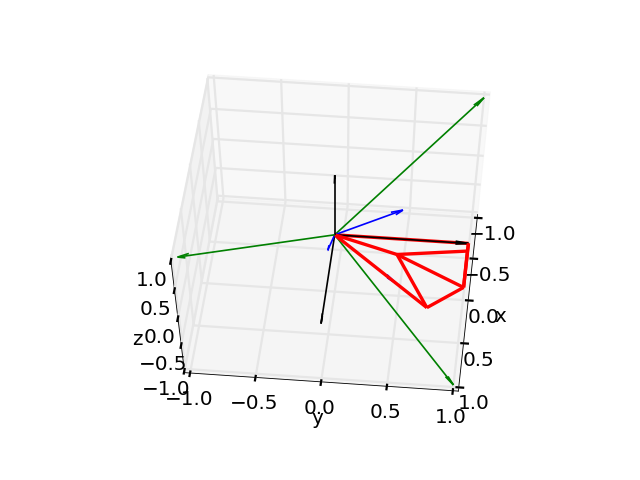

In [22]:
cs = [[1,0,0], [0,1,0], [0,0,1]]
fig1 = get_scene3d()
plot_vec(vec, pos=pos, color='r', lw=3.)
plot_vec(cs, ahl=0.1, color='k', lw=1.5)
plot_vec(prim, ahl=0.1, color='b', lw=1.5)
plot_vec(recipr, ahl=0.1, color='g', lw=1.5)
plt.show(fig1)

In [5]:
fig1.savefig('test.pdf')

In [8]:
p1 = np.array([3./8, 3./8, 3./4]) # K
p2 = [5./8, 1./4, 5./8] # U
print (lat.SymPts['K'])
print (lat.SymPts['U'])

[ 4.71  4.71  0.  ]
[ 1.57  6.28  1.57]
